In [11]:
import sys
import os
sys.path.append('Jerome_scripts_Original/PGM/')
sys.path.append('selfPackages/')
sys.path.append('Jerome_scripts_Original/')

import numpy as np
import scipy as sc
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import rbm
    import bm
except:
    print 'Compiling cy_utilities first'
    curr_dir = os.getcwd()
    os.chdir('PGM/')
    !python setup.py build_ext --inplace
    print 'Compilation done'
    os.chdir(curr_dir)
    
import pickle
from ising import IsingModel
import estimate_correlations_ising
from sklearn.utils import shuffle
import inlineMovies

In [12]:
def beta_from_corrLength(corrLen):
    beta = np.tan((np.exp(-1./corrLen)))
    return beta

In [24]:
#corrLengths = np.array([0.1,0.5,1.,5,10.,20.,50,100])
#corrLengths = np.array([2**2,2**2,2**2,2**2,2**2])
corrLengths  = np.zeros(20) + 4
beta = beta_from_corrLength(corrLengths)
print beta
print corrLengths

[ 0.98689153  0.98689153  0.98689153  0.98689153  0.98689153  0.98689153
  0.98689153  0.98689153  0.98689153  0.98689153  0.98689153  0.98689153
  0.98689153  0.98689153  0.98689153  0.98689153  0.98689153  0.98689153
  0.98689153  0.98689153]
[ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.]


In [30]:
#Defining Parameters
Num_configs = 10000
Nstep       = beta*1000/1.5 #The number of Markov Chain steps for no correlation in the input data. This number was dec
                            # by checking the numebr of steps required for highest beta value which is 1000, which we scale further down.
#N           = corrLengths*30 #The 30 factor was obtained by previous simulations where the system performed well with this sytems size

N = np.linspace(20,210,20)

print N

for i in np.arange(len(N)):
    N[i] = np.int(max(30,np.int(N[i]))) # We fix the minimum number of spins to 30

#Change the array type to int array from float array
N = N.astype(int)
Nstep = Nstep.astype(int)

[  20.   30.   40.   50.   60.   70.   80.   90.  100.  110.  120.  130.
  140.  150.  160.  170.  180.  190.  200.  210.]


In [ ]:
BM      = []
data    = []
results = []
RBM     = []

for i in np.arange(len(beta)):
    #Generate spins using Gibbs Sampling MCMC
    BM.append(bm.BM(N=N[i],nature='Spin'))

    #Define Couplings
    BM[i].layer.couplings =  beta[i]*(np.eye(N=N[i],k=1) + np.eye(N=N[i],k=-1) )
    BM[i].layer.couplings[0,-1] += beta[i]
    BM[i].layer.couplings[-1,0] += beta[i]
    
    #Generating the ising model data
    data.append(BM[i].gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=Nstep[i])) # N steps.

    #Train the model
    RBM.append(rbm.RBM(visible = 'Spin', n_v=N[i], n_h = 1, hidden = 'Spin',zero_field = True))
    results.append(RBM[i].fit(data[i],n_iter=250,verbose=0,learning_rate = 0.001,record=['W'],record_interval=100,batch_size=10,N_MC= 20, lr_decay=False,batch_norm=False))

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 54
Starting epoch 55
Starting epoch 56
S

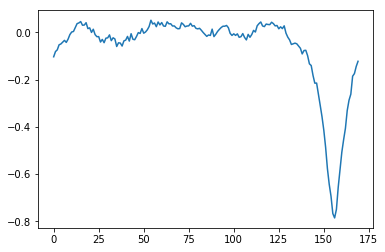

In [47]:
plt.plot(np.roll(np.array(results[15]['W'])[-1,0,:],-5))

In [59]:
del results[0]

[  5.70886289  24.75486454]


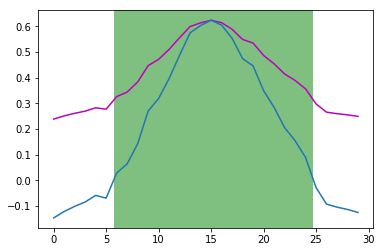

[ 13.44984123  26.76220977]


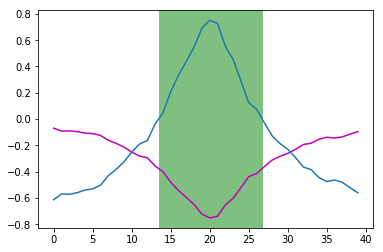

[ 18.77961128  31.42532889]


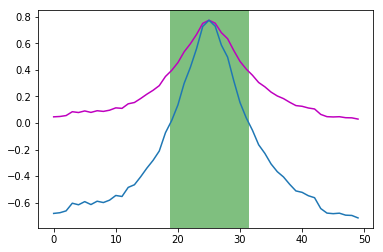

[ 24.01776154  35.55482956]


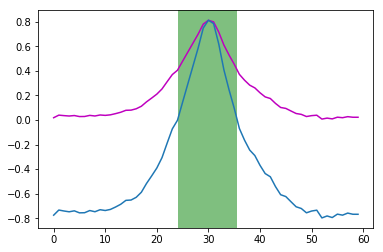

[ 28.12953287  41.08474186]


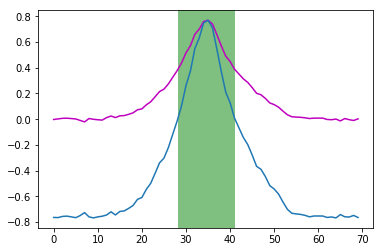

[ 32.30885441  46.40029642]


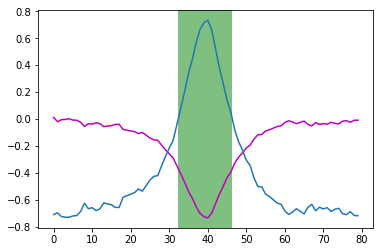

[ 39.30349486  51.84249956]


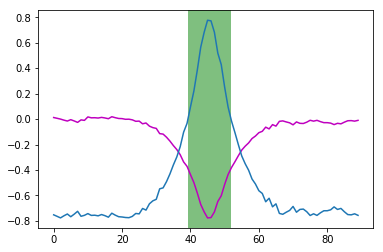

[ 44.55942155  55.01365683]


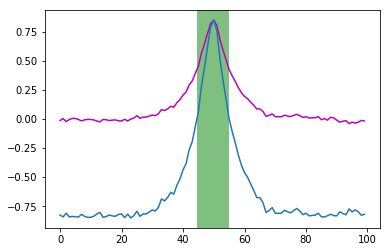

[ 48.19402713  61.98205141]


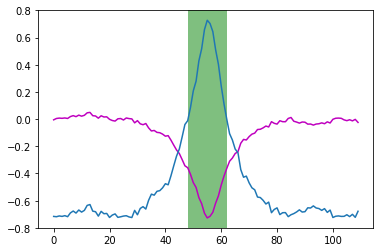

[ 52.09615195  67.19874185]


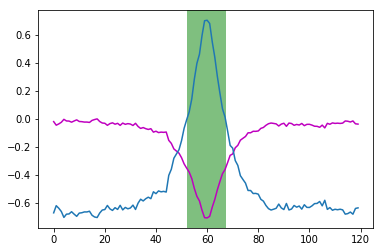

[ 58.2232169  72.5205459]


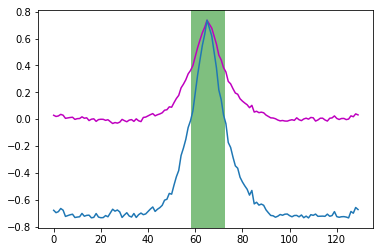

[ 63.23884198  75.84298523]


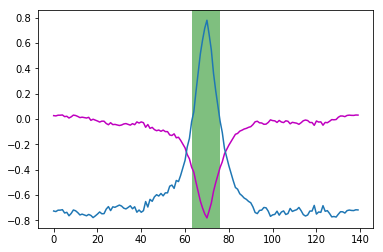

[ 69.58758943  80.63173789]


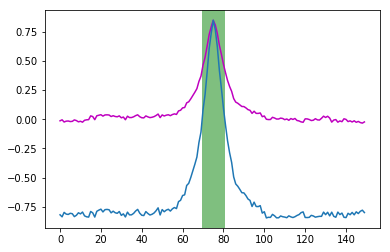

[ 73.62155345  86.45184803]


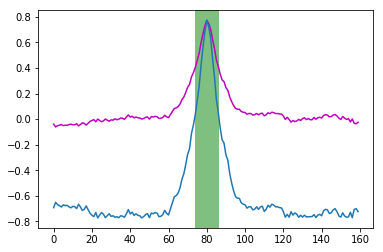

[ 78.64103367  91.19283396]


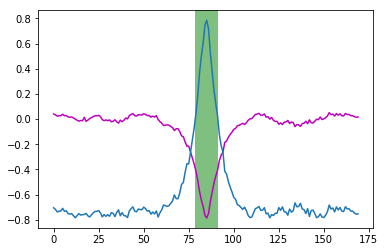

[ 82.27567854  96.78655835]


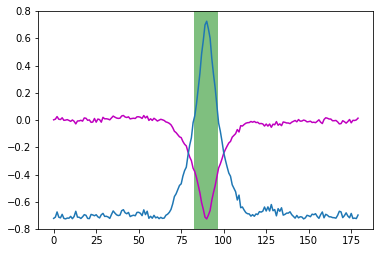

[  87.90493178  102.52359503]


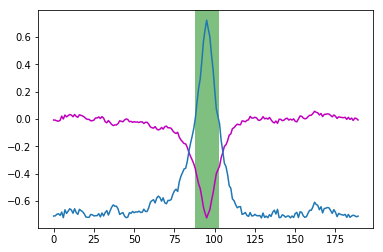

[  93.04382413  106.89606307]


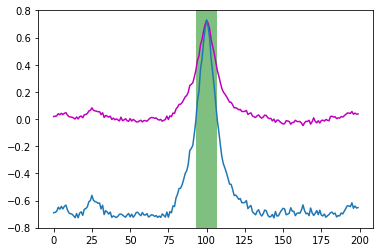

[  98.67356002  110.2319318 ]


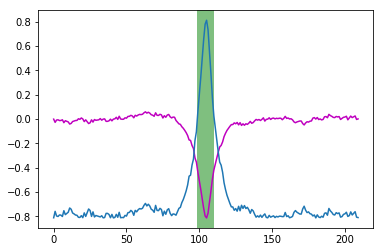

[19.046001648969405, 13.312368536996001, 12.645717608521849, 11.537068025726548, 12.955208994061621, 14.091442007633141, 12.539004697925257, 10.454235278527904, 13.78802427972014, 15.102589895560484, 14.29732900555323, 12.604143249753434, 11.044148459963552, 12.830294583218176, 12.551800297764885, 14.510879806548587, 14.618663251728776, 13.852238944316682, 11.558371781028541]


In [60]:
# Fitting the Peak and calculating the width

from scipy.interpolate import UnivariateSpline
import pylab as pl

#Roll the array to put the peak in the centre
weightsAligned = []
spline = []
roots  = []
FWHM   = []

#for i in np.arange(len(beta)):
for i in np.arange(len(beta)-1):
    roll_val = -(np.argmax(abs(np.array(results[i]['W'])[-1,0,:])) - int(len(np.array(results[i]['W'])[-1,0,:])/2))
    weightsAligned.append(np.roll(np.array(results[i]['W'])[-1,0,:],roll_val))
    spline.append(UnivariateSpline(np.arange(len(np.array(results[i]['W'])[-1,0,:])),abs(weightsAligned[i])-np.max(abs(weightsAligned[i]))/2,s=0))
    roots.append(spline[i].roots())
    
    #Show the roots for visual verification
    pl.plot(np.arange(len(np.array(results[i]['W'])[-1,0,:])),weightsAligned[i],'m')
    pl.plot(2*spline[i](np.arange(len(np.array(results[i]['W'])[-1,0,:]))))
    print(roots[i])
    pl.axvspan(roots[i][0], roots[i][1], facecolor='g', alpha=0.5)
    pl.show()
    #I = input("Press Enter to continue...")
    
    FWHM.append(abs(roots[i][0]-roots[i][1]))
    
print FWHM
#plt.plot(np.array(results[1]['W'])[-1,0,:])

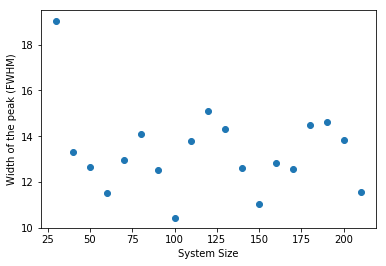

In [62]:
#Plot FWHM as a function of the system size

plt.scatter(N[1:],FWHM)
plt.xlabel('System Size')
plt.ylabel('Width of the peak (FWHM)')
plt.show()

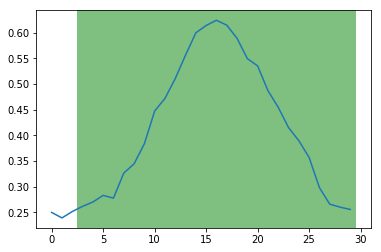

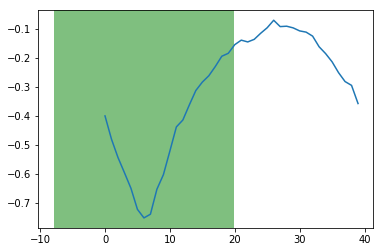

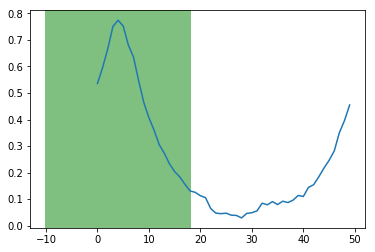

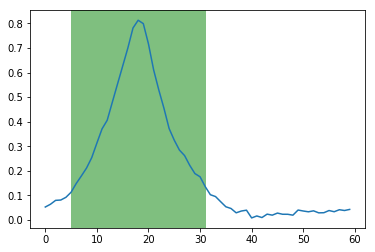

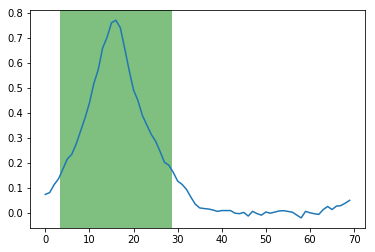

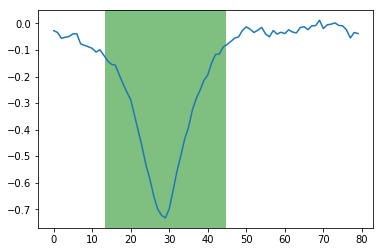

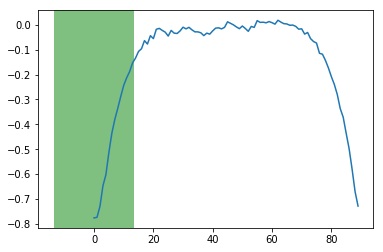

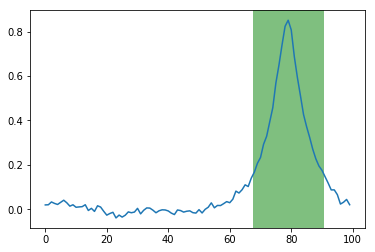

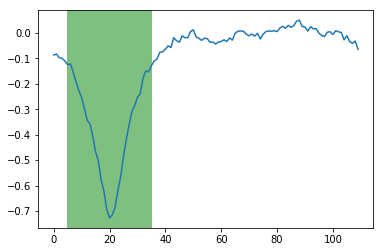

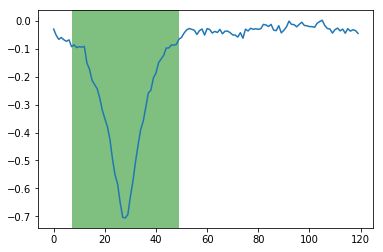

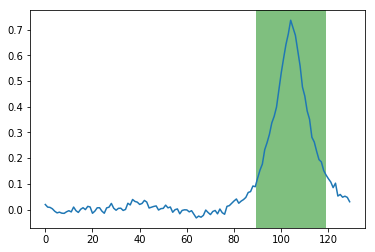

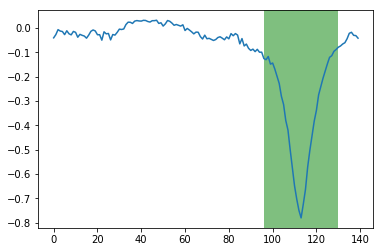

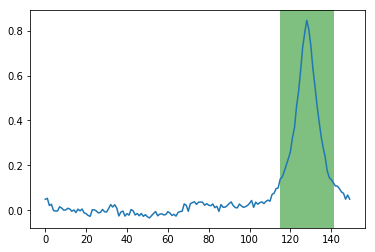

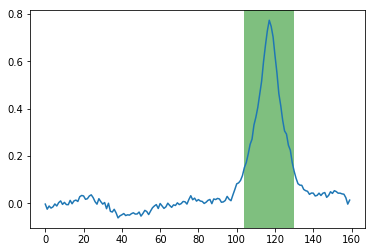

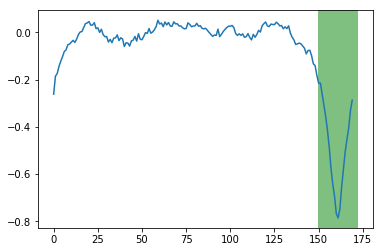

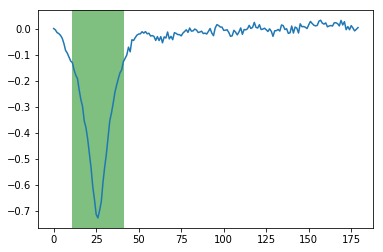

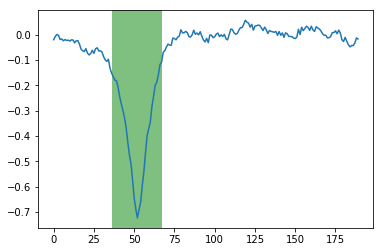

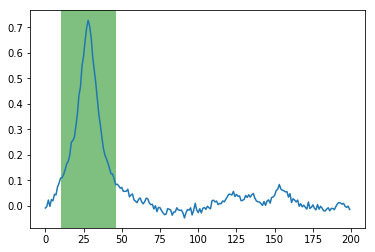

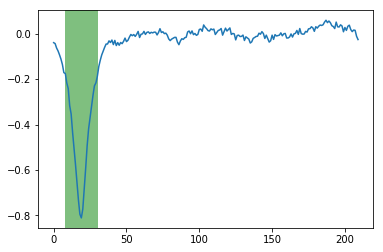

In [66]:
import peakWidth
#reload(peakWidth)
width = []
avg_width = []
for i in np.arange(len(beta)-1):
    
    width.append(peakWidth.peakWidth(np.array(results[i]['W'])[:,0,:],plot=True,method='Squared')) 
    avg_width.append(np.sum(width[i])/1)

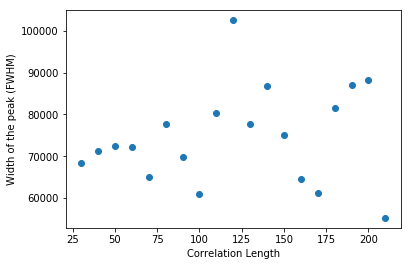

In [67]:
plt.scatter(N[1:],avg_width)
plt.xlabel('Correlation Length')
plt.ylabel('Width of the peak (FWHM)')
plt.show()